# Hamoye Capstone Project: Age & Gender Detection

### by : Beanstalk

The dataset includes a CSV of facial images that are labeled on the basis of age, gender, and ethnicity.The dataset includes 27305 rows and 5 columns, age, ethnicity, gender, img_name and pixels.

The project will be based on a CNN (Conventional Neutral Networks) model to detect the variables of interest (Age & Gender). In order to reach that we have to follow some steps which are included in the methodology.

## Methodology of the project:
The project will be devised into 5 parts:
1. Data Collection and Assessment
2. Data Cleaning and wrangling
3. Data Visualization 
4. Features engineering
5. Data Modeling and Evaluation

## Data Collection and Assessment
Firstly we have to collect our dataset, fortunately the dataset is provided by kaggle and we can easy import it to our project directly through kaggle API. Please following the code bellow to import the data without errors.

In [ ]:

# we have to install kaggle via pip
! pip install -q kaggle

In [ ]:

# we need to import the json file that contains kaggle API 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuunogasay","key":"6c165d2e90a0ae99c7cf1cf54784159e"}'}

In [ ]:

# The following code will make a directory
# will move the json file inside it and give it authority 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:

# we download our dataset using the following code
!kaggle datasets download nipunarora8/age-gender-and-ethnicity-face-data-csv

 92% 58.0M/63.2M [00:00<00:00, 162MB/s]
100% 63.2M/63.2M [00:00<00:00, 154MB/s]


In [ ]:

# Since it's downloaded in zip format, we have to extract it
! unzip /content/age-gender-and-ethnicity-face-data-csv.zip

Archive:  /content/age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


### Read data
After collection our dataset, now we have to import it and assess it using different assessement methods.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from sklearn.utils import shuffle
from PIL import Image
from tqdm import tqdm

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, Dense, LSTM, Flatten, MaxPooling2D, BatchNormalization, Dropout
from sklearn.metrics import f1_score
from sklearn import metrics

In [ ]:

# we import the dataset using the following code
df = pd.read_csv('/content/age_gender.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


## Data Cleaning and Wrangling
After we assessed the data and showed the data quality problems that we have to clean, the following part is dedicated to perform a cleaning and wrangling for the data in order to make it useful for the next part which is the visualization part.

In [ ]:

# we drop the unused columns from the dataset
df.drop(columns=['ethnicity', 'img_name'], inplace=True)

In [ ]:

# We extract the pixels from pixels column to make them tidy
new_cols = []

for i in range(len(df)):
    row = df.iloc[i]['pixels']
    values = row.split()
    new_cols.append(values)

# Create new dataframe with separated values
new_df = pd.DataFrame(new_cols)

# Print new dataframe
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,129,128,128,126,127,130,133,135,139,142,...,123,129,134,138,142,144,144,146,146,146
1,164,74,111,168,169,171,175,182,184,188,...,168,189,223,241,236,232,204,182,170,148
2,67,70,71,70,69,67,70,79,90,103,...,117,113,116,116,117,117,115,112,111,108
3,193,197,198,200,199,200,202,203,204,205,...,218,222,227,228,228,230,231,235,239,246
4,202,205,209,210,209,209,210,211,212,214,...,165,167,167,167,168,171,171,167,163,161


In [ ]:

# Let's see the first 5 lines of the data
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,129,128,128,126,127,130,133,135,139,142,...,123,129,134,138,142,144,144,146,146,146
1,164,74,111,168,169,171,175,182,184,188,...,168,189,223,241,236,232,204,182,170,148
2,67,70,71,70,69,67,70,79,90,103,...,117,113,116,116,117,117,115,112,111,108
3,193,197,198,200,199,200,202,203,204,205,...,218,222,227,228,228,230,231,235,239,246
4,202,205,209,210,209,209,210,211,212,214,...,165,167,167,167,168,171,171,167,163,161


In [ ]:
# Convert the dataframe column to float, and replace non-numeric values with NaN
new_df = new_df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [ ]:
# print the dimensions of the pixels
np.sqrt(new_df.shape[1])

48.0

In [ ]:
df.drop(columns=['pixels'], inplace=True)

In [ ]:
new_df.to_csv("/content/Inputs.csv", index=False)

In [ ]:
df.to_csv("/content/Outputs.csv", index=False)

## Data Visualization
After we cleaned our data and made it ready for use, in this part we will visualize our dataset in order to understand it and summarize it into beautiful and meaningful visualizations. We will also use the `imshow()` function from Matplotlib library to visualize or to show some pixels of our dataset (Face pictures).

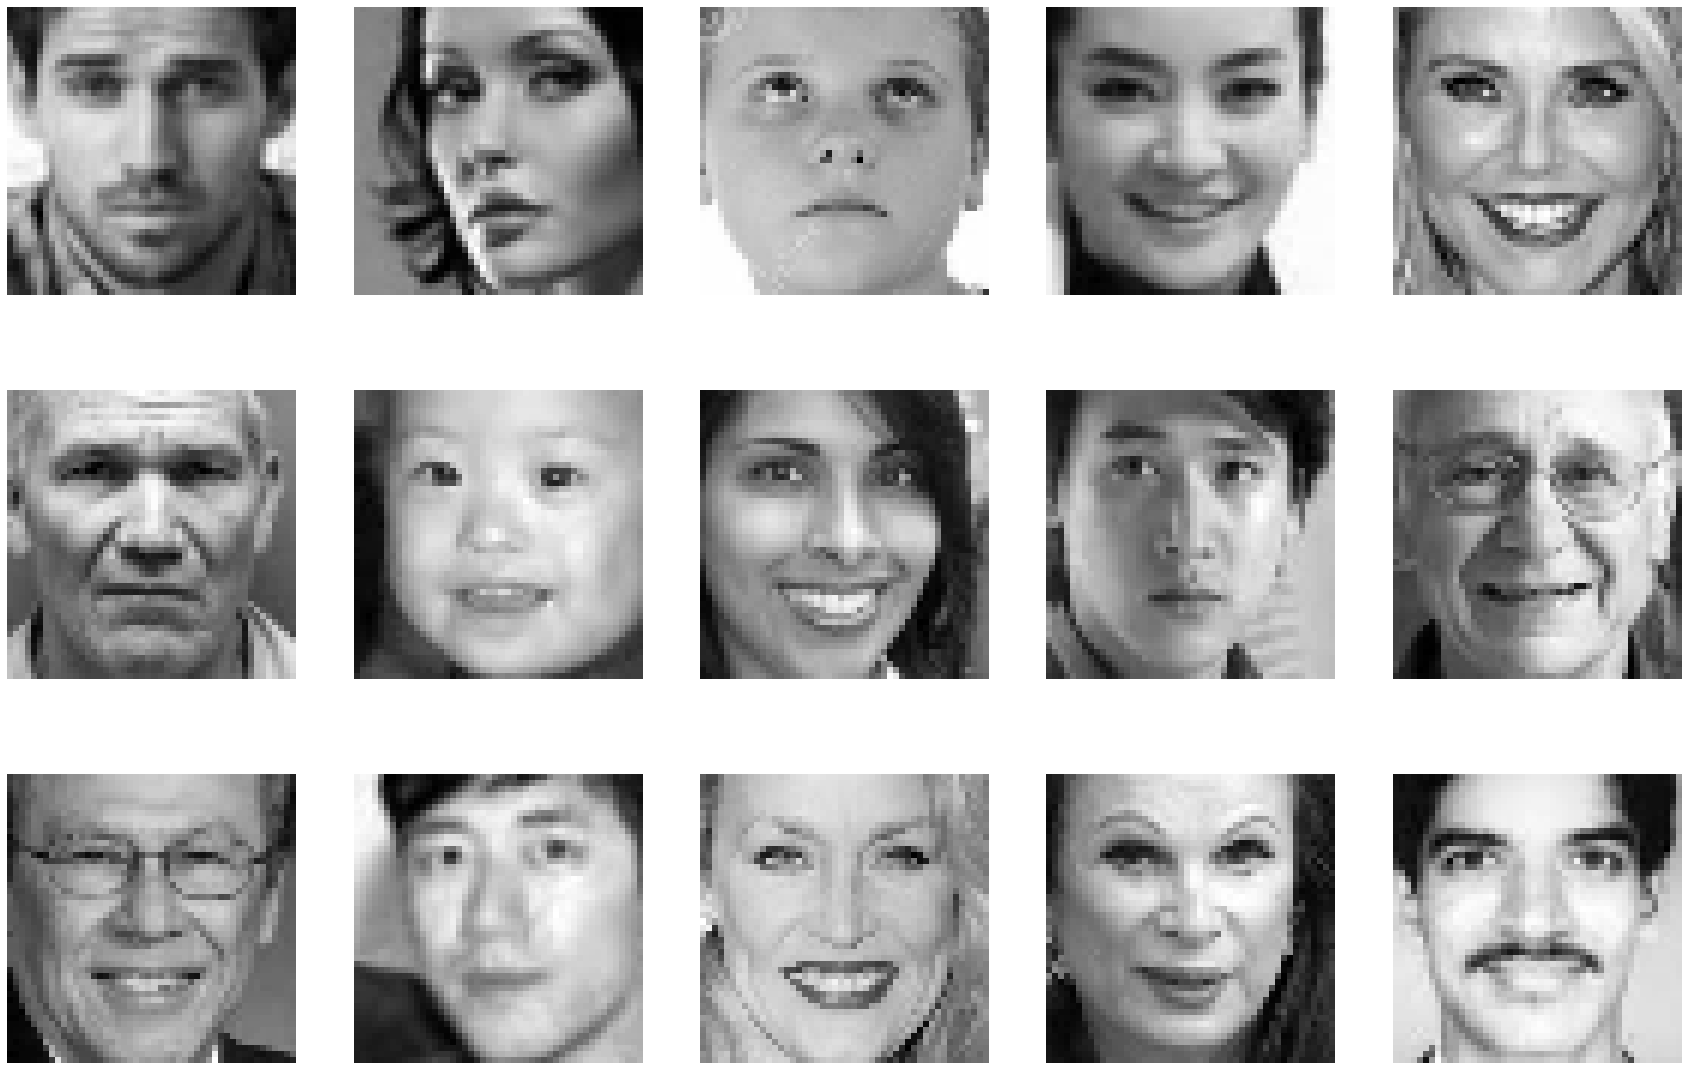

In [ ]:
# The following code will select random rows (images) and visualize them

random_rows = random.sample(range(len(new_df)), 15)
images = new_df.iloc[random_rows, :]
#images = new_df.iloc[:30, :] #This is for 1st 30 rows.

# Plot random 15 images
fig, axs = plt.subplots(3, 5, figsize=(30, 20))

for i, ax in enumerate(axs.flat):
    ax.imshow(images.iloc[i].values.reshape(48, 48), cmap="gray")
    ax.axis("off")

plt.show()

### Features engineering

In [ ]:
X = pd.read_csv("/content/Inputs.csv")

In [ ]:
Y = pd.read_csv("/content/Outputs.csv")

Reshape the data from (23705, 2304) to (23705, 48, 48, 1) where the last dimension represents the number of channels in the image (1 for grayscale, 3 for RGB).

Normalize the data between 0 and 1 by dividing it with 255.

In [ ]:
X = np.array(X)
X = X.reshape(-1, 48, 48, 1)

In [ ]:
X = X / 255.0

In [ ]:
X.shape, Y.shape

((23705, 48, 48, 1), (23705, 2))

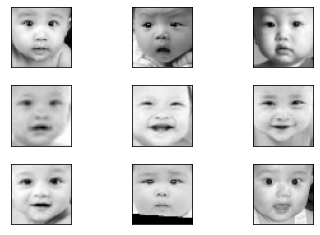

In [ ]:
def plot_images(X):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].reshape(48, 48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

plot_images(X[:9])

In [ ]:
y_age= np.array(Y['age'])
y_gender= np.array(Y['gender'])

In [22]:
X_gender_train, X_gender_test, y_gender_train, y_gender_test = train_test_split(X, y_gender, train_size=0.8, random_state=42)
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X, y_age, train_size=0.8, random_state=42)

### Data Modeling and Evaluation

In [24]:
inputs = tf.keras.Input(shape=(48, 48, 1))
x = inputs

x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Age prediction branch
age = tf.keras.layers.Dense(1, name='age')(x)

# Gender prediction branch
gender = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(x)

model = tf.keras.Model(inputs=inputs, outputs=[age, gender])
model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['mae', 'accuracy'])

# Training the model
history = model.fit(X_gender_train, [y_age_train, y_gender_train],validation_split=0.2, epochs=50, batch_size=64, validation_data=(X_gender_test, [y_age_test, y_gender_test]), callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],)

Epoch 1/50
297/297 [==============================] - 60s 198ms/step - loss: 444.1965 - age_loss: 443.4987 - gender_loss: 0.6979 - age_mae: 16.1732 - age_accuracy: 0.0478 - gender_mae: 0.4986 - gender_accuracy: 0.5116 - val_loss: 347.8319 - val_age_loss: 347.1404 - val_gender_loss: 0.6916 - val_age_mae: 14.2602 - val_age_accuracy: 0.0443 - val_gender_mae: 0.4987 - val_gender_accuracy: 0.5041 - lr: 0.0010
Epoch 2/50
297/297 [==============================] - 55s 184ms/step - loss: 291.5042 - age_loss: 290.8927 - gender_loss: 0.6114 - age_mae: 13.1546 - age_accuracy: 0.0472 - gender_mae: 0.4291 - gender_accuracy: 0.6607 - val_loss: 211.3486 - val_age_loss: 210.8118 - val_gender_loss: 0.5368 - val_age_mae: 11.2134 - val_age_accuracy: 0.0413 - val_gender_mae: 0.3567 - val_gender_accuracy: 0.7275 - lr: 0.0010
Epoch 3/50
297/297 [==============================] - 54s 183ms/step - loss: 208.5437 - age_loss: 207.9965 - gender_loss: 0.5473 - age_mae: 10.9876 - age_accuracy: 0.0418 - gender_mae:

In [27]:
# Evaluating the model
metrics = model.evaluate(X_gender_test, [y_age_test, y_gender_test], batch_size=64)

# Printing the evaluation metrics
print("Loss: ", metrics[0])
print("Age Loss: ", metrics[1])
print("Gender Loss: ", metrics[2])
print("Age MAE: ", metrics[3])
print("Gender Accuracy: ", metrics[6])

75/75 [==============================] - 4s 50ms/step - loss: 91.1529 - age_loss: 90.8593 - gender_loss: 0.2936 - age_mae: 6.8992 - age_accuracy: 0.0297 - gender_mae: 0.1847 - gender_accuracy: 0.8688
Loss:  91.15288543701172
Age Loss:  90.85930633544922
Gender Loss:  0.2935935854911804
Age MAE:  6.899173259735107
Gender Accuracy:  0.8688040375709534


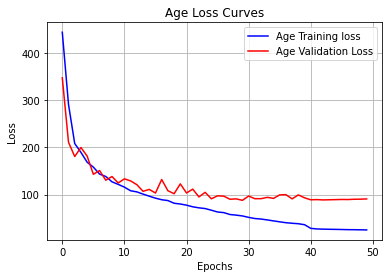

In [43]:
# Check for overfitting for age

plt.figure()

plt.plot(history.history['age_loss'], 'blue')
plt.plot(history.history['val_age_loss'], 'red')

plt.legend(['Age Training loss', 'Age Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Age Loss Curves')
plt.grid()

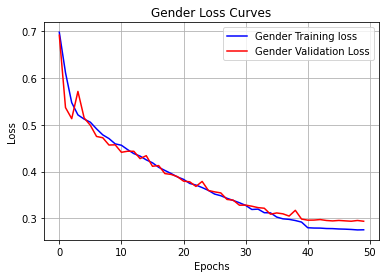

In [44]:
# Check for overfitting for Gender

plt.figure()

plt.plot(history.history['gender_loss'], 'blue')
plt.plot(history.history['val_gender_loss'], 'red')

plt.legend(['Gender Training loss', 'Gender Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Gender Loss Curves')
plt.grid()